# Bright SNe lightcurves
### Roy Williams
Grab some bright supernovae and plot them.  Demo of:
* /query/
* /lightcurves/

### Python (3 only) requirements - pip install
lasair, matplotlib


In [7]:
import sys, time
import matplotlib.pyplot as plt
import numpy as np

### Grab my Lasair API token
Get your token before you start.  If you haven't got a Lasair account you can register here: https://lasair-iris.roe.ac.uk/signup.  Use the curl command below to get your token & set the last line of the next cell to be your token ID. 

```bash
curl --data "username=tutorial&password=***********" https://lasair-iris.roe.ac.uk/api/auth-token/
```
You should get the following response:
```json
{"token":"acf14c2788ec5d7abb351f06e9ce2624a810b2ab"}
```
We can use this token temporarily, but note that it will be disabled after the workshop!

In [8]:
from lasair import LasairError, lasair_client as lasair

try:
    import settings
    token = settings.token
except:
    token = 'acf14c2788ec5d7abb351f06e9ce2624a810b2ab'
L = lasair(token)

### Query for objects with the Sherlock classification SN

In [9]:
conditions = """
sherlock_classifications.classification = "SN"
AND objects.gmag < 19 AND objects.rmag < 19
AND objects.ncandgp > 12
"""

In [10]:
rows = L.query(
    'objects.objectId', 
    'objects, sherlock_classifications', 
    conditions, 
    limit=10)
objectIds = [row['objectId'] for row in rows]

### Plot lightcurve function

In [11]:
def plotLC(lightcurve):
    objectId = lightcurve['objectId']
    jd_now = time.time()/86400 + 40587.0 + 2400000.5
    color = {1:'green', 2:'red'}
    for fid in [1,2]:
        since = []
        magpsf = []
        sigmapsf = []
        for cand in lightcurve['candidates']:
            if cand['fid'] == fid:
                since.append(cand['jd'] - jd_now)
                magpsf.append(cand['magpsf'])
                sigmapsf.append(cand['sigmapsf'])
        plt.errorbar(since, magpsf, yerr=sigmapsf, c=color[fid])
        plt.xlabel("days before %.2f" % jd_now)
        plt.ylabel("psf mag")
        plt.title('https://lasair-iris.roe.ac.uk/objects/%s' % objectId)
    plt.gca().invert_yaxis()
    plt.show()

### Grab and plot the lightcurves

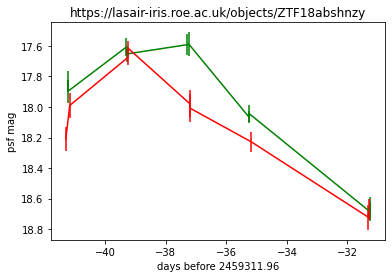

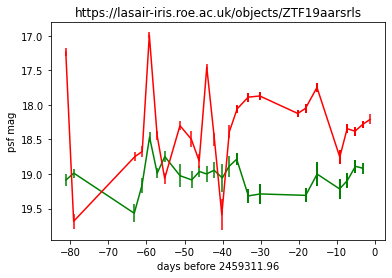

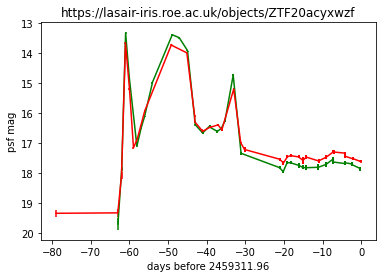

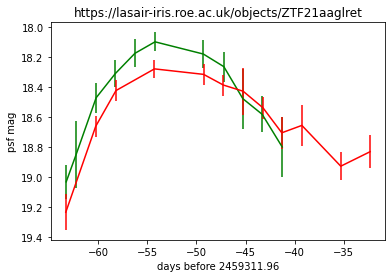

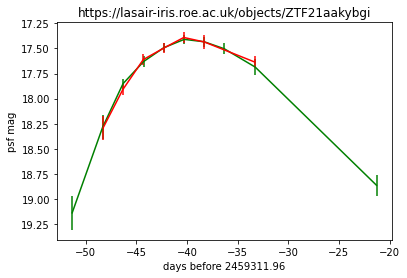

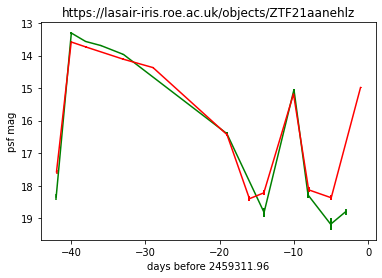

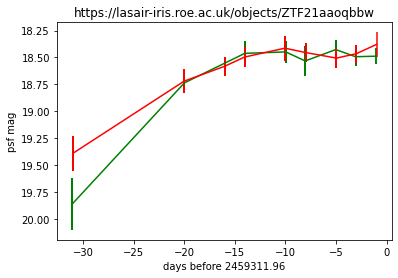

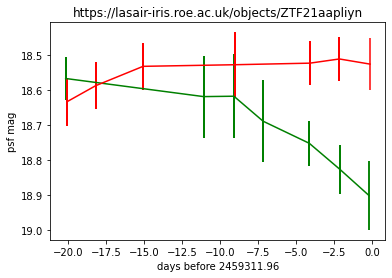

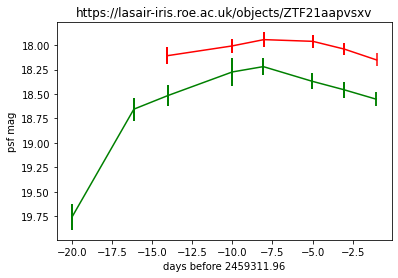

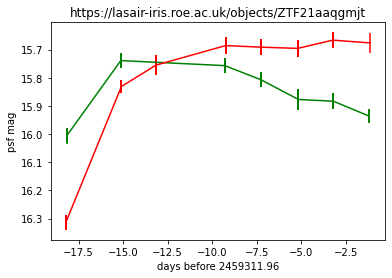

In [12]:
lcs = L.lightcurves(objectIds)
for lc in lcs:
    plotLC(lc)